#Package Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
st_scaler = StandardScaler()

#Data prep

In [ ]:
#Reading the data
power = pd.read_csv("https://raw.githubusercontent.com/zeitgeist-hash/GRAD-C24-Machine-Learning/main/Tetuan%20City%20power%20consumption.csv")

##Exploring raw data

In [ ]:
power.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52416 entries, 0 to 52415
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   DateTime                   52416 non-null  object 
 1   Temperature                52416 non-null  float64
 2   Humidity                   52416 non-null  float64
 3   Wind Speed                 52416 non-null  float64
 4   general diffuse flows      52416 non-null  float64
 5   diffuse flows              52416 non-null  float64
 6   Zone 1 Power Consumption   52416 non-null  float64
 7   Zone 2  Power Consumption  52416 non-null  float64
 8   Zone 3  Power Consumption  52416 non-null  float64
dtypes: float64(8), object(1)
memory usage: 3.6+ MB


In [ ]:
power.describe()

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
count,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000
mean,18.810024,68.259518,1.959489,182.696614,75.028022,32344.970564,21042.509082,17835.406218
std,5.815476,15.551177,2.348862,264.400960,124.210949,7130.562564,5201.465892,6622.165099
min,3.247000,11.340000,0.050000,0.004000,0.011000,13895.696200,8560.081466,5935.174070
25%,14.410000,58.310000,0.078000,0.062000,0.122000,26310.668692,16980.766032,13129.326630
50%,18.780000,69.860000,0.086000,5.035500,4.456000,32265.920340,20823.168405,16415.117470
75%,22.890000,81.400000,4.915000,319.600000,101.000000,37309.018185,24713.717520,21624.100420
max,40.010000,94.800000,6.483000,1163.000000,936.000000,52204.395120,37408.860760,47598.326360


##Transforming data

In [ ]:
#Formatting the columns
power["DT"] = pd.to_datetime(power["DateTime"])
power.columns = power.columns.str.replace(' ', '')
power=power.rename(columns={"generaldiffuseflows": "GeneralDiffuseFlows", "diffuseflows": "DiffuseFlows", "Zone1PowerConsumption":"Zone1", "Zone2PowerConsumption":"Zone2","Zone3PowerConsumption":"Zone3"})

#Aggregate consumption
power["MeanConsumption"] = power[['Zone1', 'Zone2', 'Zone3']].mean(axis=1)

#Inserting dummy variables for temporal data -- some of these may be redundant
power["Month"]=pd.DatetimeIndex(power['DT']).month
power["DayOfMonth"]=pd.DatetimeIndex(power['DT']).day # returns day of month from 1 to 31
power["DayOfWeek"]=pd.DatetimeIndex(power['DT']).weekday # day of week from 0 to 6
power["Weekday"] = (pd.DatetimeIndex(power['DT']).weekday < 5).astype(int) # 1-0 dummy for weekday or not
power["Hour"]=pd.DatetimeIndex(power['DT']).hour
power["Week"]=pd.DatetimeIndex(power['DT']).week

#Seasons: 
seasons = [1,1,2,2,2,3,3,3,4,4,4,1]
month_to_season = dict(zip(range(1,13), seasons))
power["Season"]=power.DT.dt.month.map(month_to_season) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  from ipykernel import kernelapp as app


In [ ]:
power.head(-10)

,DateTime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,Zone1,Zone2,Zone3,DT,MeanConsumption,Month,DayOfMonth,DayOfWeek,Weekday,Hour,Week,Season
0,1/1/2017 0:00,6.559,73.80,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386,2017-01-01 00:00:00,23475.178480,1,1,6,0,0,52,1
1,1/1/2017 0:10,6.414,74.50,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434,2017-01-01 00:10:00,23106.947957,1,1,6,0,0,52,1
2,1/1/2017 0:20,6.313,74.50,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373,2017-01-01 00:20:00,22601.073977,1,1,6,0,0,52,1
3,1/1/2017 0:30,6.121,75.00,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711,2017-01-01 00:30:00,21829.744030,1,1,6,0,0,52,1
4,1/1/2017 0:40,5.921,75.70,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964,2017-01-01 00:40:00,21216.815423,1,1,6,0,0,52,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52401,12/30/2017 21:30,7.950,70.20,0.082,0.062,0.085,35297.33840,30852.40871,16589.67587,2017-12-30 21:30:00,27579.807660,12,30,5,0,21,52,1
52402,12/30/2017 21:40,7.650,71.10,0.082,0.084,0.093,34591.63498,30347.95950,16485.95438,2017-12-30 21:40:00,27141.849620,12,30,5,0,21,52,1
52403,12/30/2017 21:50,8.140,69.73,0.081,0.062,0.085,34469.96198,29688.86161,16180.55222,2017-12-30 21:50:00,26779.791937,12,30,5,0,21,52,1
52404,12/30/2017 22:00,8.090,68.49,0.079,0.070,0.085,34920.15209,29445.84228,16053.78151,2017-12-30 22:00:00,26806.591960,12,30,5,0,22,52,1


##Hourly aggregate

In [ ]:
#Creating a new dataframe with hourly aggregates
power_hour = power.groupby(["Month", "Day", "Hour"], as_index=False).mean().copy()
power_hour["Year"] = 2017
power_hour["DT"] = pd.to_datetime(power_hour[["Year", "Month", "Day", "Hour"]])
power_hour = power_hour.set_index('DT')

,Month,DayOfMonth,Hour,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,Zone1,Zone2,Zone3,MeanConsumption
0,1,1,0,6.196833,75.066667,0.081833,0.063500,0.098833,29197.974683,18026.747720,19252.048193,22158.923532
1,1,1,1,5.548833,77.583333,0.082000,0.056833,0.112500,24657.215190,16078.419453,17042.891567,19259.508737
2,1,1,2,5.054333,78.933333,0.082333,0.063000,0.129167,22083.037973,14330.699088,15676.144578,17363.293880
3,1,1,3,5.004333,77.083333,0.082833,0.059833,0.141000,20811.139240,13219.452887,14883.855422,16304.815849
4,1,1,4,5.097667,74.050000,0.082333,0.058000,0.122833,20475.949367,12921.580547,14317.108433,15904.879449
...,...,...,...,...,...,...,...,...,...,...,...,...
8731,12,30,19,9.453333,62.406667,0.074667,0.052000,0.102000,37513.814957,32497.698680,16926.770708,28979.428115
8732,12,30,20,9.041667,63.990000,0.080333,0.052667,0.105000,37008.871988,32020.251610,16998.799520,28675.974373
8733,12,30,21,8.011667,69.675000,0.081500,0.073167,0.098333,35358.174905,30757.901197,16608.883553,27574.986552
8734,12,30,22,7.598333,70.315000,0.081833,0.058667,0.108167,33993.409380,28477.447070,15614.885955,26028.580802


##Visualizing data

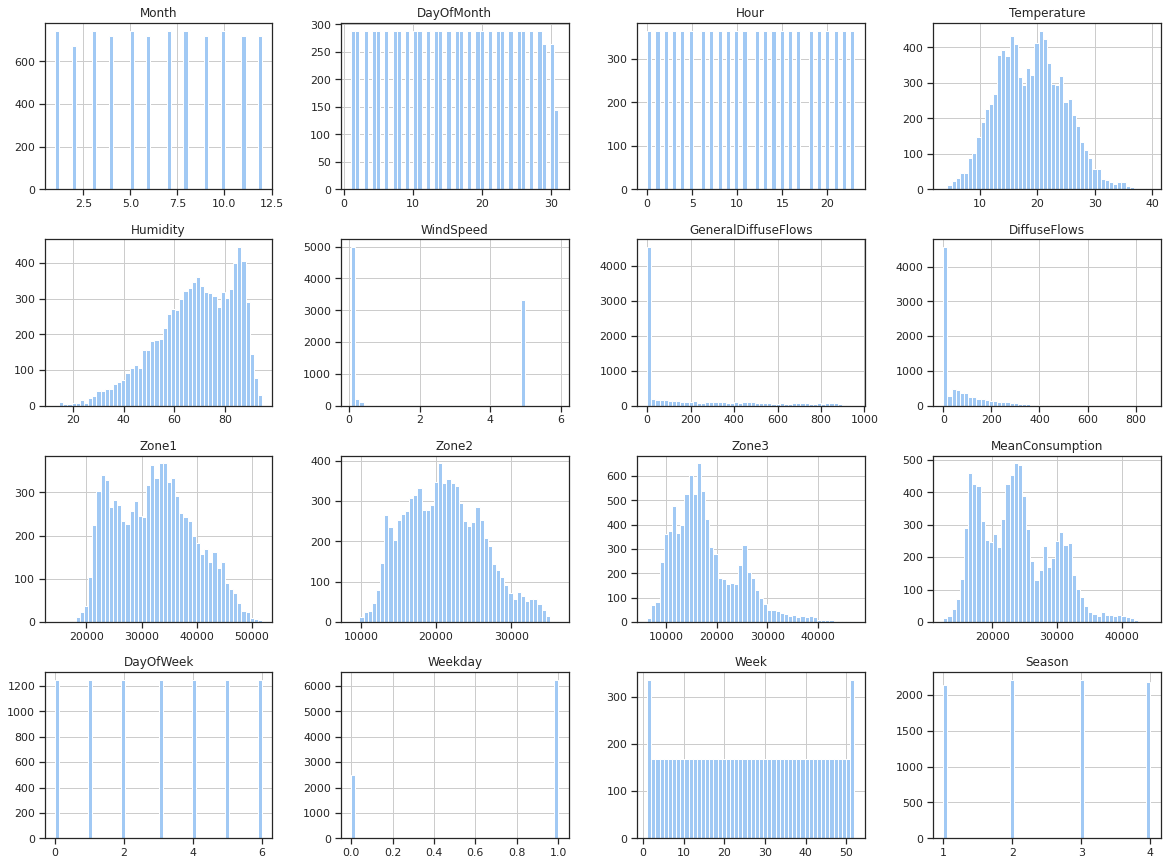

In [ ]:
%matplotlib inline
power_hour.hist(bins=50, figsize=(20,15))
plt.show()

###Windspeed

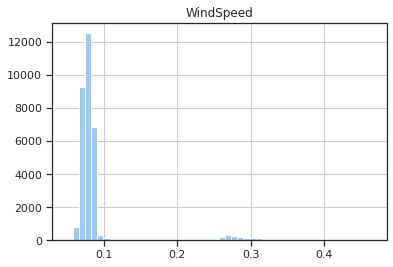

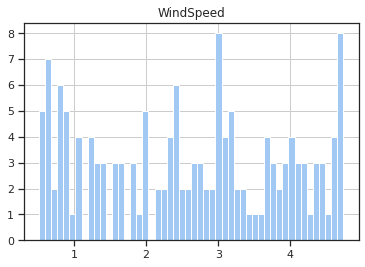

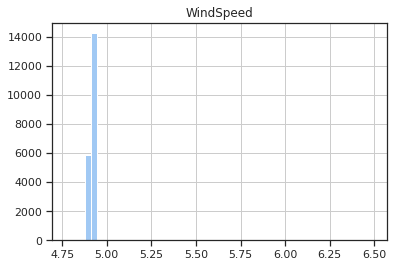

In [ ]:
# Further analysis into windspeed, which has 2 peaks at ~0 and ~5, with very few observations in between

# Subset 1
wind_subset1 = power[power['WindSpeed']<0.5].copy() # first peak, 32049 observations, about 61% of total obs
# Means: temp of 16.6, humidity 69.9, GDF 154.7, DF 75.
# Month counts: most obs in november - april, fewest occurrences during july-august (summer). Winter months?
hist1 = wind_subset1.hist(column = "WindSpeed", bins=50)

# Subset 2
wind_subset2 = power[(power['WindSpeed']>0.5) & (power['WindSpeed']< 4.75)].copy() # intermediate range, only 149 observations, about 0.3% of total obs
# Means: temp of 19, humidity 62, GDF 217.4, DF 134.6.
# Month counts: most during may-november, fewest during september-august-june, but strange distribution. Outliers for summer months?
wind_subset2.value_counts("Month")
hist2 = wind_subset2.hist(column = "WindSpeed", bins=50)

# Subset 3
wind_subset3 = power[power['WindSpeed']>4.75].copy() # second peak, 20218 observations, about 39% of total obs
# Means: temp of 22.3, humidity 65.6, GDF 226.9, DF 74.7.
# Months: most during may - september, least december - april. Summer months?
hist3 = wind_subset3.hist(column = "WindSpeed", bins=50)


No handles with labels found to put in legend.


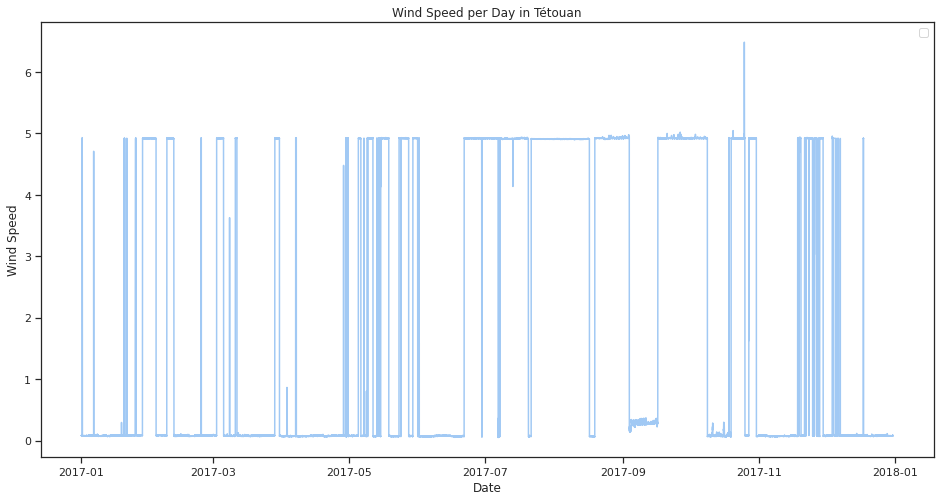

In [ ]:
# Visualize
x_wind=power["DT"]
y_wind=power["WindSpeed"]

plt.figure(figsize=(16,8))
plt.plot(x_wind, y_wind)

plt.xlabel('Date')
plt.ylabel('Wind Speed')
plt.title("Wind Speed per Day in Tétouan")
plt.legend()
plt.show()

###Diffuse and General Diffuse Flows

No handles with labels found to put in legend.


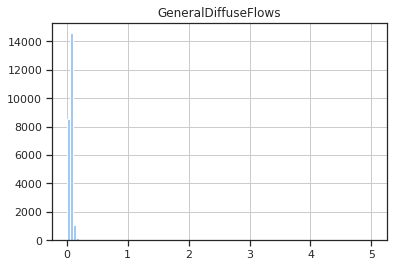

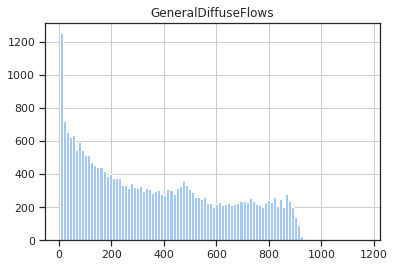

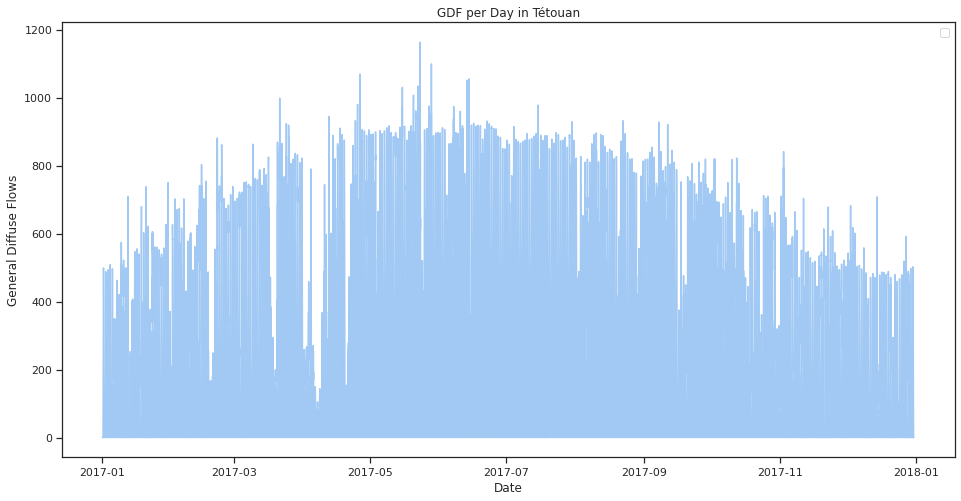

In [ ]:
# General diffuse flows, very right skewed
# Appears to be an hourly phenomenon, with energy consumption being much higher during the day and lower at night (due to business operations?)
gdf1 = power[power["GeneralDiffuseFlows"]<5].copy()
gdf1['month'] = pd.DatetimeIndex(gdf1['DT']).month
gdf1["hour"]= pd.DatetimeIndex(gdf1['DT']).hour

gdf2 = power[power["GeneralDiffuseFlows"]>5].copy()
gdf2['month'] = pd.DatetimeIndex(gdf2['DT']).month
gdf2["hour"]= pd.DatetimeIndex(gdf2['DT']).hour

#print(len(gdf1), len(gdf2))
# Gdf1 (values under 5) and Gdf2 (from 5 to 1200) have a roughly even number of observations

#gdf1.value_counts("month") # more winter than summer
#gdf2.value_counts("month") # summer rather than winter
#gdf1.value_counts("hour") # 21:00 - 05:00 
gdf2.value_counts("hour") # 08:00 - 17:00

gdfHist1 = gdf1.hist(column = "GeneralDiffuseFlows", bins=100)
gdfHist2 = gdf2.hist(column = "GeneralDiffuseFlows", bins=100)

# Visualize
x_gdf=power["DT"]
y_gdf=power["GeneralDiffuseFlows"]

plt.figure(figsize=(16,8))
plt.plot(x_gdf, y_gdf)

plt.xlabel('Date')
plt.ylabel('General Diffuse Flows')
plt.title("GDF per Day in Tétouan")
plt.legend()
plt.show()

# Notable dip around April, peaks in summer. Is this perhaps an hourly phenomenon, rather than monthly?

Text(0.5, 1.0, 'DF per Day in Tétouan')

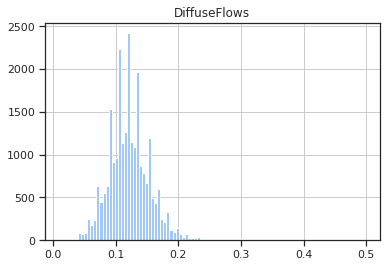

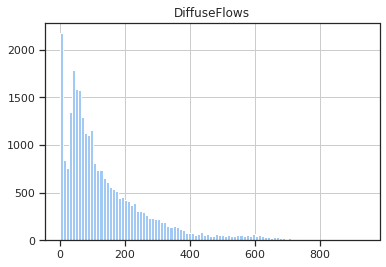

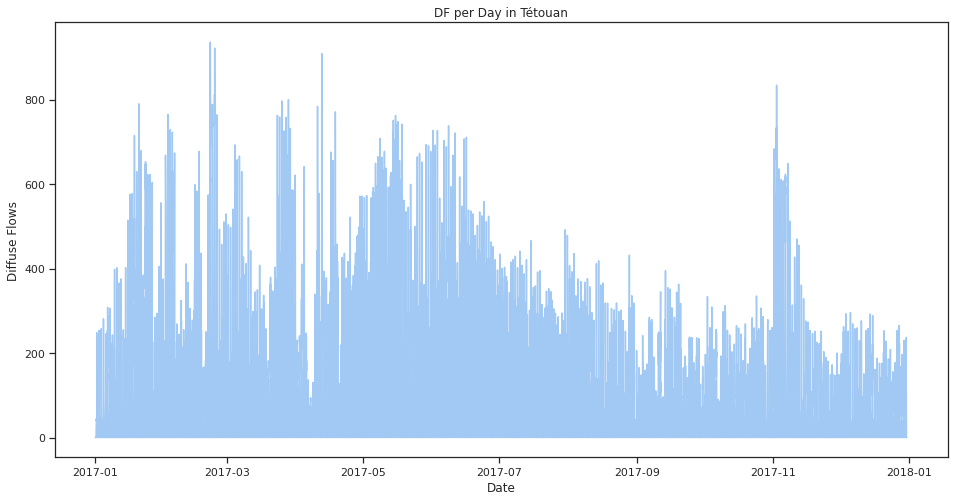

In [ ]:
# Diffuse flows
# Appears to be an hourly phenomenon, with energy consumption being much higher during the day and lower at night (due to business operations?)

df1 = power[power["DiffuseFlows"]<0.5].copy()
df1['month'] = pd.DatetimeIndex(df1['DT']).month
df1['hour'] = pd.DatetimeIndex(df1['DT']).hour

df2 = power[power["DiffuseFlows"]>0.5].copy()
df2['month'] = pd.DatetimeIndex(df2['DT']).month
df2['hour'] = pd.DatetimeIndex(df2['DT']).hour

#print(len(df1), len(df2))
# (0 to 0.5) and (0.5 to 800) have a 47-53% split

#df1.value_counts("month") # more winter than summer
#df2.value_counts("month") # summer rather than winter
df1.value_counts("hour") # 21:00 - 05:00 
#df2.value_counts("hour") # 08:00 - 18:00

dfHist1 = df1.hist(column = "DiffuseFlows", bins=100)
dfHist2 = df2.hist(column = "DiffuseFlows", bins=100)

# Visualize
x_df=power["DT"]
y_df=power["DiffuseFlows"]

plt.figure(figsize=(16,8))
plt.plot(x_df, y_df)

plt.xlabel('Date')
plt.ylabel('Diffuse Flows')
plt.title("DF per Day in Tétouan")
#plt.show()
# Low in April, August - October, December

###Zone visualization

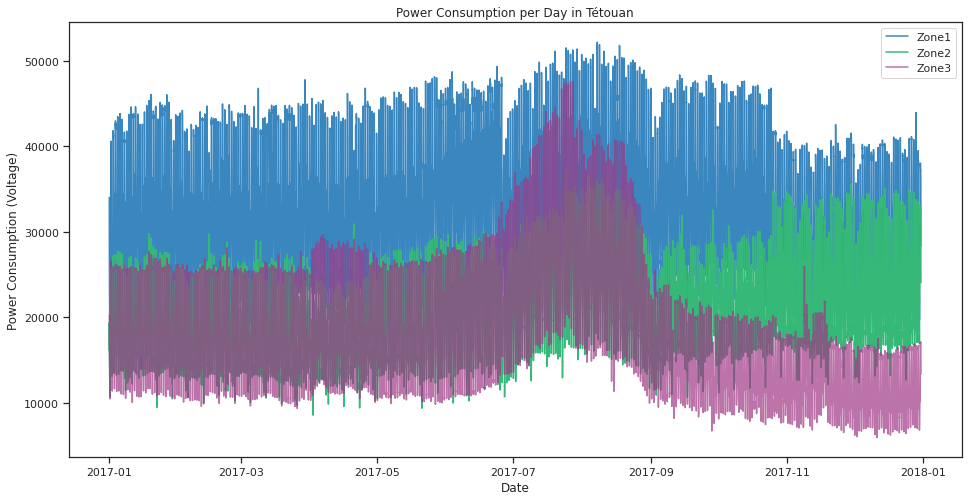

In [ ]:
#Plotting energy consumption per datetime in all tree. 
x=power["DT"]
y1=power["Zone1"]
y2=power["Zone2"]
y3=power["Zone3"]

plt.figure(figsize=(16,8))
plt.plot(x, y1, label = "Zone1", color="#3a87c0")
plt.plot(x, y2, label = "Zone2", color="#36b878")
plt.plot(x, y3, label = "Zone3",color ="#a03885", alpha=0.7)

plt.xlabel('Date')
plt.ylabel('Power Consumption (Voltage)')
plt.title("Power Consumption per Day in Tétouan")
plt.legend()
plt.show()

### Aggregated mean visualization

In [ ]:
#Plotting mean energy consumption for all zones
x=power_hour.index
y1=power_hour["MeanConsumption"]

plt.figure(figsize=(16,8))
plt.plot(x, y1, label = "Mean Consumption", color="orange")

plt.xlabel('Date')
plt.ylabel('Power Consumption (kWh)')
plt.title("Power Consumption per Day in Tétouan")
plt.legend()
plt.show()

###Exploring temporal data correlations

In [ ]:
#Creating a Dataframe to explore temporal correlations
power1=power.iloc[:, 6:11]

#Inserting dummy variables for temporal data
power1["Month"]= power1.DT.dt.month
power1["Day"]= power1.DT.dt.day
power1["Hour"]= power1.DT.dt.hour
power1["Week"]= power1.DT.dt.week

#Seasons: 
seasons1 = [1,1,2,2,2,3,3,3,4,4,4,1]
month_to_season1 = dict(zip(range(1,13), seasons1))
power1["Season"]=power1.DT.dt.month.map(month_to_season1) 

power1.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


,Zone1,Zone2,Zone3,DT,MeanConsumption,Month,Day,Hour,Week,Season
0,34055.69620,16128.87538,20240.96386,2017-01-01 00:00:00,23475.178480,1,1,0,52,1
1,29814.68354,19375.07599,20131.08434,2017-01-01 00:10:00,23106.947957,1,1,0,52,1
2,29128.10127,19006.68693,19668.43373,2017-01-01 00:20:00,22601.073977,1,1,0,52,1
3,28228.86076,18361.09422,18899.27711,2017-01-01 00:30:00,21829.744030,1,1,0,52,1
4,27335.69620,17872.34043,18442.40964,2017-01-01 00:40:00,21216.815423,1,1,0,52,1


In [ ]:
tcorr_matrix = power1.corr()
tcorr_matrix

,Zone1,Zone2,Zone3,MeanConsumption,Month,Day,Hour,Week,Season
Zone1,1.000000,0.834519,0.750733,0.959146,-5.346049e-03,2.627309e-02,7.279525e-01,-7.760804e-03,1.292922e-01
Zone2,0.834519,1.000000,0.570932,0.871069,3.202665e-01,5.294130e-02,6.633590e-01,3.197327e-01,1.607570e-01
Zone3,0.750733,0.570932,1.000000,0.871777,-2.339260e-01,-4.782920e-03,4.542566e-01,-2.352722e-01,2.763672e-02
MeanConsumption,0.959146,0.871069,0.871777,1.000000,4.587168e-03,2.514365e-02,6.795321e-01,2.900795e-03,1.132297e-01
Month,-0.005346,0.320266,-0.233926,0.004587,1.000000e+00,4.349864e-03,-5.911819e-16,9.813175e-01,5.835493e-01
Day,0.026273,0.052941,-0.004783,0.025144,4.349864e-03,1.000000e+00,-9.891896e-17,7.206759e-02,1.166706e-02
Hour,0.727953,0.663359,0.454257,0.679532,-5.911819e-16,-9.891896e-17,1.000000e+00,-5.787242e-16,-1.561881e-16
Week,-0.007761,0.319733,-0.235272,0.002901,9.813175e-01,7.206759e-02,-5.787242e-16,1.000000e+00,5.685946e-01
Season,0.129292,0.160757,0.027637,0.113230,5.835493e-01,1.166706e-02,-1.561881e-16,5.685946e-01,1.000000e+00


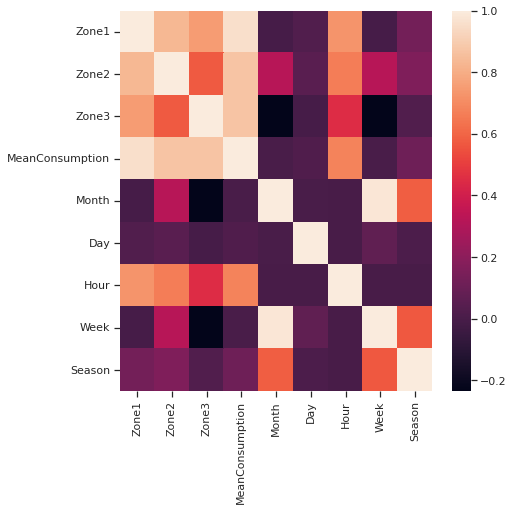

In [ ]:
#Plot of the correlation matrix with temporal data
plt.figure(figsize=(7,7))
sns.heatmap(tcorr_matrix)

Exploring correlations 

In [ ]:
#finding correlation among all numeric non temporal variables (except for date and time) 
corr_matrix = power.corr()
corr_matrix

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,Zone1,Zone2,Zone3,MeanConsumption,Month,DayOfMonth,DayOfWeek,Weekday,Hour,Week,Season
Temperature,1.000000,-0.460243,0.477109,0.460294,0.196522,0.440221,0.382428,0.489527,0.488238,2.843350e-01,1.926774e-02,-1.370995e-02,2.559087e-02,1.971305e-01,2.678390e-01,5.587897e-01
Humidity,-0.460243,1.000000,-0.135853,-0.468138,-0.256886,-0.287421,-0.294961,-0.233022,-0.299059,-1.741931e-02,-4.540307e-02,-1.711388e-02,-2.416129e-02,-2.426916e-01,-2.067148e-02,-2.871568e-02
WindSpeed,0.477109,-0.135853,1.000000,0.133733,-0.000972,0.167444,0.146413,0.278641,0.221706,1.683554e-01,1.640667e-01,3.211641e-02,-2.765614e-02,4.148645e-03,1.730946e-01,3.509600e-01
GeneralDiffuseFlows,0.460294,-0.468138,0.133733,1.000000,0.564718,0.187965,0.157223,0.063376,0.150368,-2.055450e-02,3.225334e-02,9.666328e-03,-5.086016e-03,1.299766e-01,-2.127817e-02,7.252524e-02
DiffuseFlows,0.196522,-0.256886,-0.000972,0.564718,1.000000,0.080274,0.044667,-0.038506,0.032068,-1.297793e-01,-2.827775e-02,-2.453960e-02,1.627708e-02,1.309090e-01,-1.354902e-01,-4.913388e-02
Zone1,0.440221,-0.287421,0.167444,0.187965,0.080274,1.000000,0.834519,0.750733,0.959146,-5.346049e-03,2.627309e-02,-6.970813e-02,7.347804e-02,7.279525e-01,-7.760804e-03,1.292922e-01
Zone2,0.382428,-0.294961,0.146413,0.157223,0.044667,0.834519,1.000000,0.570932,0.871069,3.202665e-01,5.294130e-02,-1.226819e-01,1.531880e-01,6.633590e-01,3.197327e-01,1.607570e-01
Zone3,0.489527,-0.233022,0.278641,0.063376,-0.038506,0.750733,0.570932,1.000000,0.871777,-2.339260e-01,-4.782920e-03,5.294106e-03,-1.409693e-02,4.542566e-01,-2.352722e-01,2.763672e-02
MeanConsumption,0.488238,-0.299059,0.221706,0.150368,0.032068,0.959146,0.871069,0.871777,1.000000,4.587168e-03,2.514365e-02,-6.417293e-02,7.159655e-02,6.795321e-01,2.900795e-03,1.132297e-01
Month,0.284335,-0.017419,0.168355,-0.020554,-0.129779,-0.005346,0.320266,-0.233926,0.004587,1.000000e+00,4.349864e-03,6.387829e-03,-1.515007e-03,-5.911819e-16,9.813175e-01,5.835493e-01


In [ ]:
#Zoom in into Zone1 Consumption
corr_matrix["Zone1"].sort_values(ascending=False)

Zone1                  1.000000
MeanConsumption        0.959146
Zone2                  0.834519
Zone3                  0.750733
Hour                   0.727953
Temperature            0.440221
GeneralDiffuseFlows    0.187965
WindSpeed              0.167444
Season                 0.129292
DiffuseFlows           0.080274
Weekday                0.073478
DayOfMonth             0.026273
Month                 -0.005346
Week                  -0.007761
DayOfWeek             -0.069708
Humidity              -0.287421
Name: Zone1, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa43a962090>,
      dtype=object)

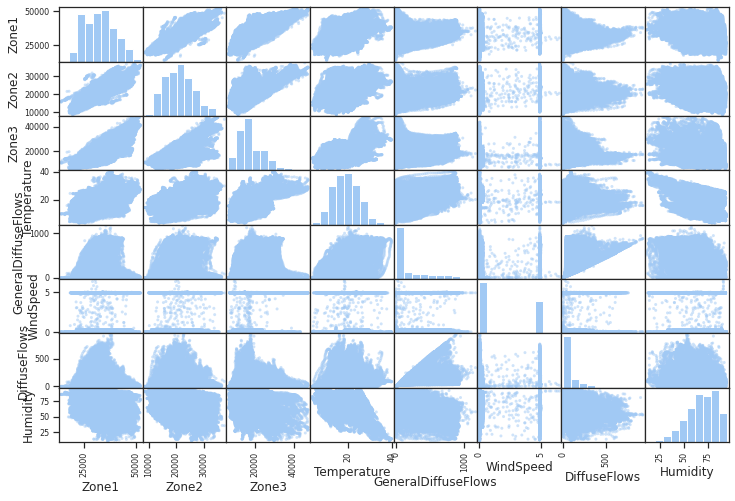

In [ ]:
#Plotting correlations for Zone1
from pandas.plotting import scatter_matrix
attributes = ["Zone1", "Zone2", "Zone3", "Temperature", "GeneralDiffuseFlows", "WindSpeed", "DiffuseFlows", "Humidity"]
scatter_matrix(power[attributes], figsize=(12, 8))

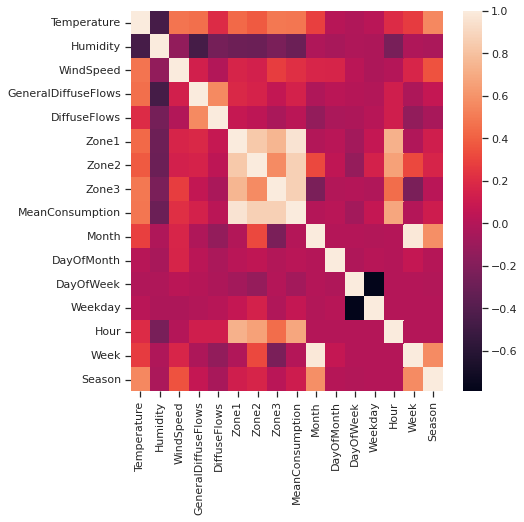

In [ ]:
#Plot of the correlation matrix
plt.figure(figsize=(7,7))
sns.heatmap(corr_matrix)

###Weekly distribution of power consumption

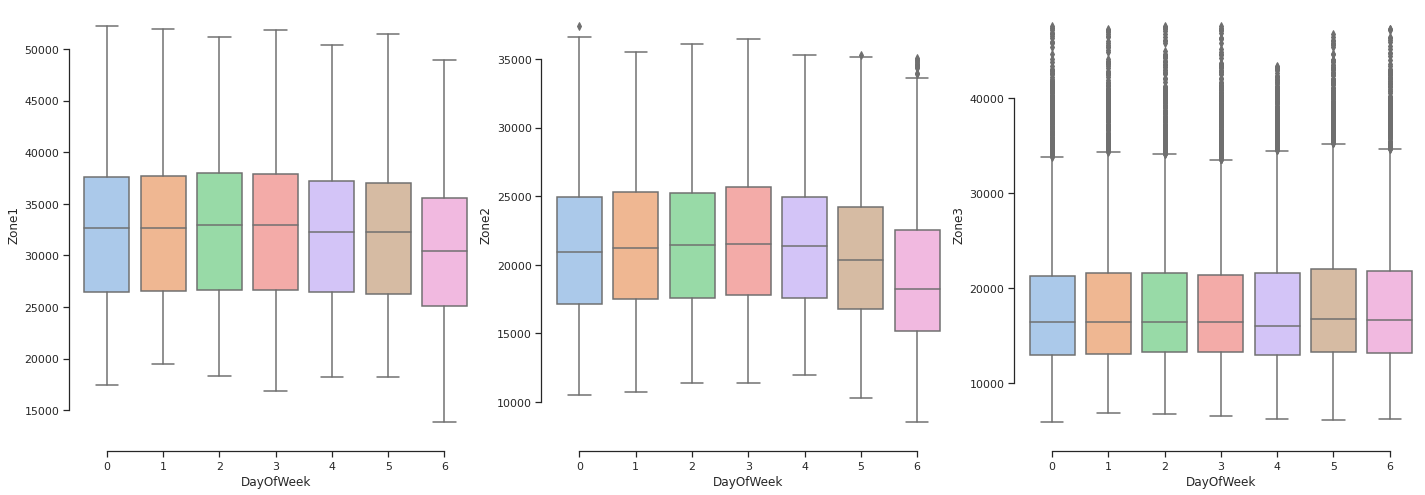

In [ ]:
#Weekly distribution of the power consumption
sns.set_theme(style="ticks", palette="pastel")

fig, axes = plt.subplots(1, 3, figsize=(24, 8))



# Draw a nested boxplot to show bills by day and time
sns.boxplot(ax=axes[0], x=power["DayOfWeek"], y=power["Zone1"],data=power)
sns.boxplot(ax=axes[1], x=power["DayOfWeek"], y=power["Zone2"],data=power)
sns.boxplot(ax=axes[2], x=power["DayOfWeek"], y=power["Zone3"],data=power)
sns.despine(offset=10, trim=True)


#Selecting covariates and outcome

In [ ]:
list(power_hour.columns)

['Month',
 'DayOfMonth',
 'Hour',
 'Temperature',
 'Humidity',
 'WindSpeed',
 'GeneralDiffuseFlows',
 'DiffuseFlows',
 'Zone1',
 'Zone2',
 'Zone3',
 'MeanConsumption',
 'DayOfWeek',
 'Weekday',
 'Week',
 'Season']

In [ ]:
X = power_hour.loc[:, ["Temperature", "Humidity", "WindSpeed", "GeneralDiffuseFlows", 
                      "DiffuseFlows", "Season", "Month", "Hour", "DayOfWeek"]]
print(X, "\n")

y = power_hour.loc[:, ["MeanConsumption"]]
print("\n", y)

      Temperature   Humidity  WindSpeed  GeneralDiffuseFlows  DiffuseFlows  \
0        6.196833  75.066667   0.081833             0.063500      0.098833   
1        5.548833  77.583333   0.082000             0.056833      0.112500   
2        5.054333  78.933333   0.082333             0.063000      0.129167   
3        5.004333  77.083333   0.082833             0.059833      0.141000   
4        5.097667  74.050000   0.082333             0.058000      0.122833   
...           ...        ...        ...                  ...           ...   
8731     9.453333  62.406667   0.074667             0.052000      0.102000   
8732     9.041667  63.990000   0.080333             0.052667      0.105000   
8733     8.011667  69.675000   0.081500             0.073167      0.098333   
8734     7.598333  70.315000   0.081833             0.058667      0.108167   
8735     6.877500  72.900000   0.081500             0.060333      0.092667   

      Season  Month  Hour  DayOfWeek  
0        1.0      1     

#Train/test splitting

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)

In [ ]:
X_train_st = st_scaler.fit_transform(X_train)
X_test_st = st_scaler.transform(X_test)

#Models

## Linear Regression

In [ ]:
# Linear Regression
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [ ]:
lr.fit(X_train_st, y_train)
pred_lr = lr.predict(X_test_st)

In [ ]:
print("Coefficients: \n", lr.coef_)

print('R2: %.2f' % r2_score(y_test, pred_lr))
print("MSE: %.2f" % mean_squared_error(y_test, pred_lr))
print("MAE: %.2f" % mean_absolute_error(y_test, pred_lr))

R2: 0.64
MSE: 11469237.37
MAE: 2685.73


##ExtraTrees

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
etr = ExtraTreesRegressor()

In [ ]:
etr.fit(X_train_st, y_train)
pred_etr = etr.predict(X_test_st)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


In [ ]:
print('R2: %.2f' % r2_score(y_test, pred_etr))
print("MSE: %.2f" % mean_squared_error(y_test, pred_etr))
print("MAE: %.2f" % mean_absolute_error(y_test, pred_etr))

R2: 0.97
MSE: 840238.95
MAE: 619.72


##SVM

In [ ]:
from sklearn.svm import SVR
svm = SVR()  

In [ ]:
svm.fit(X_train_st, y_train)
pred_svm = svm.predict(X_test_st)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
print('R2: %.2f' % r2_score(y_test, pred_svm))
print("MSE: %.2f" % mean_squared_error(y_test, pred_svm))
print("MAE: %.2f" % mean_absolute_error(y_test, pred_svm))

R2: 0.06
MSE: 29776573.20
MAE: 4318.16


In [ ]:
param_grid = {'C':[1,10,100,1000],
        'gamma':[1,0.1,0.001,0.0001]}
svm_cv = GridSearchCV(svm, param_grid, cv=5)
svm_cv.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.001, 0.0001]})

In [ ]:
print(svm_cv.best_score_)
print(svm_cv.best_params_)

0.6927565950286476
{'C': 1000, 'gamma': 0.001}


In [ ]:
pred_svm_cv = svm_cv.predict(X_test_st)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
print('R2: %.2f' % r2_score(y_test, pred_svm_cv))
print("MSE: %.2f" % mean_squared_error(y_test, pred_svm_cv))

R2: 0.02
MSE: 31305948.13


##Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor()

In [ ]:
gbr.fit(X_train_st, y_train)
pred_gbr = gbr.predict(X_test_st)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
print('R2: %.2f' % r2_score(y_test, pred_gbr))
print("MSE: %.2f" % mean_squared_error(y_test, pred_gbr))
print("MAE: %.2f" % mean_absolute_error(y_test, pred_gbr))

R2: 0.93
MSE: 2106310.80
MAE: 1043.72


In [ ]:
param_grid = {'max_depth': np.arange(3,8),
        'n_estimators': np.arange(100,161,10)}
gbr_cv = GridSearchCV(gbr, param_grid, cv=5)
gbr_cv.fit(X_train_st, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'max_depth': array([3, 4, 5, 6, 7]),
                         'n_estimators': array([100, 110, 120, 130, 140, 150, 160])})

In [ ]:
print(gbr_cv.best_score_)
print(gbr_cv.best_params_)

0.9703853108887719
{'max_depth': 7, 'n_estimators': 160}


In [ ]:
pred_gbr_cv = gbr_cv.predict(X_test_st)

In [ ]:
print('R2: %.2f' % r2_score(y_test, pred_gbr_cv))
print("MSE: %.2f" % mean_squared_error(y_test, pred_gbr_cv))

R2: 0.97
MSE: 987301.99


##Autogluon

In [ ]:
!pip install autogluon

In [ ]:
import autogluon
from autogluon.tabular import TabularPredictor

In [ ]:
X_train_auto = pd.DataFrame(data=X_train_st, columns=X_train.columns)
y_train = y_train.reset_index(drop=True)
train_data = pd.concat([X_train_auto, y_reset], axis=1)

In [ ]:
X_test_auto = pd.DataFrame(data=X_test_st, columns=X_test.columns)
y_test = y_test.reset_index(drop=True)
test_data = pd.concat([X_test_auto, y_test], axis=1)

In [ ]:
pred_autogluon = TabularPredictor(label = "MeanConsumption").fit(train_data)

No path specified. Models will be saved in: "AutogluonModels/ag-20220413_184238/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20220413_184238/"
AutoGluon Version:  0.4.0
Python Version:     3.7.13
Operating System:   Linux
Train Data Rows:    6988
Train Data Columns: 9
Label Column: MeanConsumption
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (44376.608693333335, 12469.199442666666, 23723.65653, 5680.62772)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    10883.61 MB
	Train Data (Original)  Memory Usage: 0.5 MB (0.

[1000]	valid_set's rmse: 1046.08
[2000]	valid_set's rmse: 1018.22
[3000]	valid_set's rmse: 1007.01
[4000]	valid_set's rmse: 1004.75
[5000]	valid_set's rmse: 1005.1
[6000]	valid_set's rmse: 1004.44
[7000]	valid_set's rmse: 1004
[8000]	valid_set's rmse: 1006.26


	-1002.3204	 = Validation score   (root_mean_squared_error)
	13.33s	 = Training   runtime
	0.33s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's rmse: 784.854
[2000]	valid_set's rmse: 772.404
[3000]	valid_set's rmse: 769.007
[4000]	valid_set's rmse: 768.428
[5000]	valid_set's rmse: 769.042


	-768.2923	 = Validation score   (root_mean_squared_error)
	6.66s	 = Training   runtime
	0.2s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-953.0907	 = Validation score   (root_mean_squared_error)
	7.33s	 = Training   runtime
	0.2s	 = Validation runtime
Fitting model: CatBoost ...
	-777.3202	 = Validation score   (root_mean_squared_error)
	90.24s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-919.5502	 = Validation score   (root_mean_squared_error)
	2.44s	 = Training   runtime
	0.2s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-1233.771	 = Validation score   (root_mean_squared_error)
	6.09s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: XGBoost ...
	-857.3497	 = Validation score   (root_mean_squared_error)
	2.73s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-1200.9463	 = Validation score   (root_mean_squared_error)
	29.43s	 = Training   runtime
	0.01s	 = Validati

[1000]	valid_set's rmse: 760.268


	-759.4804	 = Validation score   (root_mean_squared_error)
	6.69s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-716.3439	 = Validation score   (root_mean_squared_error)
	0.33s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 172.83s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20220413_184238/")


In [ ]:
y_pred = pred_autogluon.predict(X_test_auto)
perf = pred_autogluon.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)
print("Predictions:\n", y_pred)

AssertionError: ignored

In [ ]:
pred_autogluon.leaderboard(test_data, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,CatBoost,-777.009465,-777.320245,0.028823,0.010442,90.242124,0.028823,0.010442,90.242124,1,True,6
1,WeightedEnsemble_L2,-787.978476,-716.343858,2.074219,0.642814,117.247531,0.013344,0.000465,0.330317,2,True,12
2,LightGBM,-858.339590,-768.292285,0.634048,0.200566,6.657030,0.634048,0.200566,6.657030,1,True,4
3,LightGBMLarge,-883.678511,-759.480377,0.374818,0.104661,6.687140,0.374818,0.104661,6.687140,1,True,11
4,XGBoost,-945.483568,-857.349695,0.025584,0.013332,2.727540,0.025584,0.013332,2.727540,1,True,9
5,ExtraTreesMSE,-968.191479,-919.550202,0.360322,0.202744,2.437285,0.360322,0.202744,2.437285,1,True,7
6,LightGBMXT,-1042.051825,-1002.320351,1.023186,0.326680,13.330921,1.023186,0.326680,13.330921,1,True,3
7,RandomForestMSE,-1102.724275,-953.090664,0.361163,0.202988,7.334930,0.361163,0.202988,7.334930,1,True,5
8,NeuralNetTorch,-1202.103538,-1200.946323,0.025287,0.012565,29.430232,0.025287,0.012565,29.430232,1,True,10
9,NeuralNetFastAI,-1252.902374,-1233.771048,0.059052,0.016706,6.090927,0.059052,0.016706,6.090927,1,True,8
